553467904/553467096 [==============================] - 4s 0us/step
0.8291015625 12.71219539642334
0.6318359375 2.055401563644409
0.099609375 2.2991111278533936


Text(0.5, 1.0, 'VGG Training Accuracy Over Number of Epochs on MNIST')

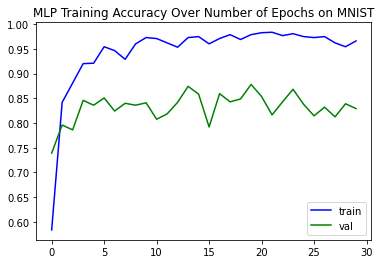

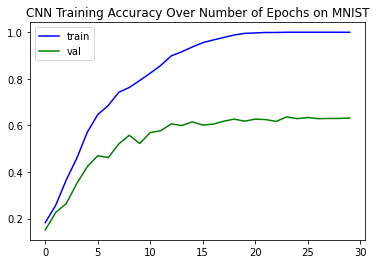

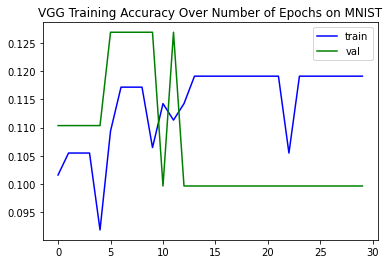

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 28 12:49:24 2020

@author: ixu10
"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from scipy.ndimage import zoom

lr_1 = 0.001
lr_2 = 0.001
lr_3 = 0.001
epochs = 30
x_epochs = np.arange(epochs)
zoom_factor = np.asarray([8, 8, 1])


def grey_to_rgb(img):
  rgb_img = np.zeros((img.shape[0], img.shape[1], 3))
  for i in range(len(img[0])):
    for j in range(len(img[1])):
      rgb_img[i][j] = np.asarray([img[i][j]]*3)
  return rgb_img

def plot_figures(x, y, y_val):
  plt.figure()
  plt.plot(x, y, "b", label="train")
  plt.plot(x, y_val, "g", label="val")
  plt.legend()

def train_hist(model, x_train, y_train, x_val, y_val, batch_size=32, epochs=1, verbose=0):
  model_hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(x_val, y_val))
  return model_hist.history

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

x_train_z = np.zeros((1024, 224, 224, 3))
x_test_z = np.zeros((1024, 224, 224, 3))

for i in range(1024):
  x_train_z[i] = zoom(grey_to_rgb(x_train[i]), zoom_factor)
  x_test_z[i] = zoom(grey_to_rgb(x_test[i]), zoom_factor)

y_train_oh = tf.keras.backend.one_hot(y_train[:1024], 10)
y_test_oh = tf.keras.backend.one_hot(y_test[:1024], 10)

base_model = VGG16()

#x = base_model.output
#predictions = Dense(10, activation="softmax")(x)

mlp_model = tf.keras.Sequential([
    MaxPool2D(pool_size=(8,8), padding='valid', input_shape=(224, 224, 3, )),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
    ])

cnn_model = tf.keras.Sequential([
    Conv2D(2, kernel_size=10, padding='valid', input_shape=(224, 224, 3, ), activation="relu"),
    MaxPool2D(pool_size=(4,4), padding='valid'),
    Conv2D(2, kernel_size=5, padding='valid', activation="relu"),
    MaxPool2D(pool_size=(2,2), padding='valid'),
    Conv2D(2, kernel_size=2, padding='valid', activation="relu"),
    Flatten(),
    Dense(10, activation="softmax")        
    ])

vgg_model = tf.keras.Sequential([
    base_model,
    Dense(10, activation="softmax")                            
    ])

for layer in vgg_model.layers[:-3]:
   layer.trainable = False

mlp_model.compile(optimizer=Adam(learning_rate=lr_1), loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.compile(optimizer=Adam(learning_rate=lr_2), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.compile(optimizer=Adam(learning_rate=lr_3), loss='categorical_crossentropy', metrics=['accuracy'])

mlp_hist = train_hist(mlp_model, x_train_z, y_train_oh, x_test_z, y_test_oh, epochs=epochs)
cnn_hist = train_hist(cnn_model, x_train_z, y_train_oh, x_test_z, y_test_oh, epochs=epochs)
vgg_hist = train_hist(vgg_model, x_train_z, y_train_oh, x_test_z, y_test_oh, epochs=epochs)

print( mlp_hist["val_accuracy"][-1], mlp_hist["val_loss"][-1])
print( cnn_hist["val_accuracy"][-1], cnn_hist["val_loss"][-1])
print( vgg_hist["val_accuracy"][-1], vgg_hist["val_loss"][-1])

mlp_acc, mlp_v_acc = mlp_hist["accuracy"], mlp_hist["val_accuracy"]
plot_figures(x_epochs, mlp_acc, mlp_v_acc)
plt.title("MLP Training Accuracy Over Number of Epochs on MNIST")

cnn_acc, cnn_v_acc = cnn_hist["accuracy"], cnn_hist["val_accuracy"]
plot_figures(x_epochs, cnn_acc, cnn_v_acc)
plt.title("CNN Training Accuracy Over Number of Epochs on MNIST")

vgg_acc, vgg_v_acc = vgg_hist["accuracy"], vgg_hist["val_accuracy"]
plot_figures(x_epochs, vgg_acc, vgg_v_acc)
plt.title("VGG Training Accuracy Over Number of Epochs on MNIST")
